<center>
# How to become a correlation wizard with the brightwind library!
</center>
***

In [1]:
import datetime
print('Last updated: {}'.format(datetime.date.today().strftime('%d %B, %Y')))

Last updated: 04 July, 2019


***

<div style='margin-top: 3em; margin-bottom: 3em;'>
</div>

## Outline:

This guide will demonstrate various techniques to correlate a sample site dataset to 4 separate reference datasets using the following steps:

- Import the brightwind library, load some sample raw data and clean it
- Import 4 sample reference datasets to use in the correlation
- Perform a ordinary least squares correlation for 1 dataset and time period
- Apply a long term adjustment to the measured wind speed time series based on the correlation results
- Perform a ordinary least squares correlation for multiple datasets and time periods

***

<div style='margin-top: 3em; margin-bottom: 3em;'>
</div>

### Import brightwind and data

In [2]:
# import the brightwind library
import brightwind as bw

In [3]:
# specify the directory of the demo dataset 
filepath = r'C:\Users\Stephen\Documents\Analysis\demo_data.csv'
# load the raw data
data = bw.load_csv(filepath)
# apply cleaning to the raw data
data = bw.apply_cleaning(data, r'C:\Users\Stephen\Documents\Analysis\demo_cleaning_file.csv')
# show the first 5 rows of the cleaned data
data.head(5)

Cleaning applied. (Please remember to assign the cleaned returned DataFrame to a variable.)


,Spd80mN,Spd80mS,Spd60mN,Spd60mS,Spd40mN,Spd40mS,Spd80mNStd,Spd80mSStd,Spd60mNStd,Spd60mSStd,...,Dir78mSStd,Dir58mS,Dir58mSStd,Dir38mS,Dir38mSStd,T2m,RH2m,P2m,PrcpTot,BattMin
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-09 15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-09 15:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-09 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-09 17:10:00,7.382,7.325,6.818,6.689,6.252,6.174,0.844,0.810,0.897,0.875,...,4.680,118.8,5.107,115.6,5.189,0.954,100.0,934.0,0.0,12.71
2016-01-09 17:20:00,7.977,7.791,8.110,7.915,8.140,7.974,0.556,0.528,0.562,0.524,...,3.123,115.9,2.960,113.6,3.540,0.863,100.0,934.0,0.0,12.69


***

<div style='margin-top: 3em; margin-bottom: 3em;'>
</div>

### Import reference datasets

For this example, we will import 4 MERRA-2 reanalysis datasets. These can be found as sample datasets within the brightwind library. We use the `load_csv()` function to load in each dataset from a csv file.

In [4]:
# load each of the 4 reanalysis datasets to its own dataframe
Merra2_NE =  bw.load_csv(r'C:\Users\Stephen\Documents\Analysis\MERRA-2_NE_2000-01-01_2017-06-30.csv')
Merra2_NW =  bw.load_csv(r'C:\Users\Stephen\Documents\Analysis\MERRA-2_NW_2000-01-01_2017-06-30.csv')
Merra2_SE =  bw.load_csv(r'C:\Users\Stephen\Documents\Analysis\MERRA-2_SE_2000-01-01_2017-06-30.csv')
Merra2_SW =  bw.load_csv(r'C:\Users\Stephen\Documents\Analysis\MERRA-2_SW_2000-01-01_2017-06-30.csv')

# show the first 5 lines of NE dataset
Merra2_NE.head(5)

,WS50m_m/s,WD50m_deg,T2M_degC,PS_hPa
DateTime,,,,
2000-01-01 00:00:00,6.840,275,4.06,997.17
2000-01-01 01:00:00,6.506,264,3.44,997.64
2000-01-01 02:00:00,7.095,254,3.12,998.39
2000-01-01 03:00:00,8.088,246,3.19,999.12
2000-01-01 04:00:00,8.386,239,3.18,999.61


***

<div style='margin-top: 3em; margin-bottom: 3em;'>
</div>

### Correlate to 1 dataset and using 1 averaging period

Next we'll perform a basic linear regression correlation using the Ordinary Least Squares method between the 80m north orientated site anemometer and the MERRA-2 dataset located to the North East. We use the 'averaging_prd' argument to set the averaging period for which the correlation should be carried out. This can be set to 10-min or multiples of ten minutes (10T, 30T) (depending on the interval of both datasets), hourly or multiples of 1 hour (1H, 2H, 3H, etc), daily or multiples of 1 day (1D, 2D, 3D, 15D, etc), monthly (1M) or yearly (1AS). Here we apply a monthly correlation. Finally we set the 'coverage_threshold', this is the minimum coverage of data within each averaging period from both the reference and site dataset that will be passed to the correlation. In this case we use a coverage threshold of 90%.

In [5]:
# set up correlation
ord_lst_sq = bw.Correl.OrdinaryLeastSquares(Merra2_NE['WS50m_m/s'], data['Spd80mN'], 
                                            averaging_prd='1M', coverage_threshold=0.90)

<div style='margin-top: 3em; margin-bottom: 3em;'>
</div>

The correlation function returns a python object. This has to be subsequently run and plotted using the commands `run()` and `plot()`.

In [6]:
# run correlation
ord_lst_sq.run()

{'Num data points': 16,
 'offset': -0.06161432045219376,
 'r2': 0.9407857754972966,
 'slope': 0.9955561116923611}


<div style='margin-top: 3em; margin-bottom: 3em;'>
</div>

The correlation has now run and the main results are returned. The slope and offset of the linear regression line are displayed along with the $R^2$  value. These results can be returned at any time using the `.show_params()` command.

In [7]:
#show parameters
ord_lst_sq.show_params()

{'Num data points': 16,
 'offset': -0.06161432045219376,
 'r2': 0.9407857754972966,
 'slope': 0.9955561116923611}


<div style='margin-top: 3em; margin-bottom: 3em;'>
</div>

To show the correlation plot along with the linear regression line we simply input:

C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Gotham Rounded'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


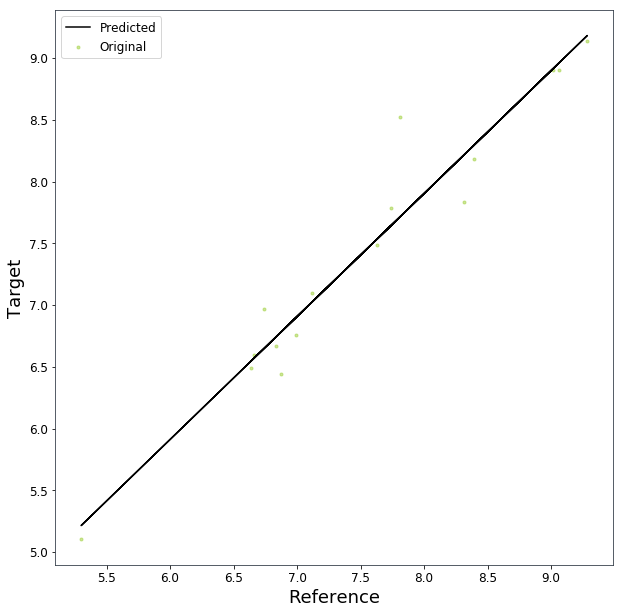

In [8]:
# show plot
ord_lst_sq.plot()

<div style='margin-top: 3em; margin-bottom: 3em;'>
</div>

Now that we have a correlation we will want to adjust our data accordingly. We can synthesize monthly Spd80mN mean wind speeds from the Merra2_NE data using the `synthesize()` method. This will synthesize monthly means for months that Spd80mN doesn't cover and splices it with months Spd80mN does cover.

In [9]:
# synthesize monthly means over the long term record
LT_monthly_means = ord_lst_sq.synthesize()
# Show the first 5 values
LT_monthly_means.head(5)

,Spd80mN_Synthesized
Timestamp,
2000-01-01,9.300975
2000-02-01,11.099150
2000-03-01,7.999968
2000-04-01,6.842368
2000-05-01,6.191083


***

<div style='margin-top: 3em; margin-bottom: 3em;'>
</div>

### Apply a long term adjustment to the measured wind speed time series based on the correlation results

We can use the results of the above correlation to rescale the Spd80mN wind speed time series and put it into a long term context. First we'll use the `momm()` (mean of monthly means) function to derive the long term mean of the dataset we synthesized above. This represents our target long term mean speed.

In [10]:
# derive long term target mean speed 
LT_target_speed = bw.momm(LT_monthly_means)
# show the value
LT_target_speed

7.623917277960366

Next, we'll derive a scale factor we can apply to the measurements to achieve this long term mean.

In [11]:
# derive scale factor as ratio of means
LT_scale_factor = LT_target_speed/data.Spd80mN.mean()
# show the value
LT_scale_factor

1.0140026948884149

Then, we can use the `scale_wind_speed()` function to rescale the measurements based on the above factor, placing them in a long term context. We'll also allocate this a new variable within the existing dataframe.

In [12]:
# scale wind speed
data['LT_Spd80mN'] = bw.scale_wind_speed(data.Spd80mN,LT_scale_factor)
# show first 5 timestamps. The new variable can be seen to the right of the dataframe.
data.head(5)

,Spd80mN,Spd80mS,Spd60mN,Spd60mS,Spd40mN,Spd40mS,Spd80mNStd,Spd80mSStd,Spd60mNStd,Spd60mSStd,...,Dir58mS,Dir58mSStd,Dir38mS,Dir38mSStd,T2m,RH2m,P2m,PrcpTot,BattMin,LT_Spd80mN
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-09 15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-09 15:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-09 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-09 17:10:00,7.382,7.325,6.818,6.689,6.252,6.174,0.844,0.810,0.897,0.875,...,118.8,5.107,115.6,5.189,0.954,100.0,934.0,0.0,12.71,7.485368
2016-01-09 17:20:00,7.977,7.791,8.110,7.915,8.140,7.974,0.556,0.528,0.562,0.524,...,115.9,2.960,113.6,3.540,0.863,100.0,934.0,0.0,12.69,8.088699


Now, let's confirm that the mean of our new variable is equal to our long term mean speed target.

In [13]:
# show ratio of mean values
data.LT_Spd80mN.mean()/LT_target_speed

0.9999999999999771

The resulting variable can then be used along with concurrent wind direction data (such as 'data.Dir78mS') to generate a tab file for wind flow modelling as shown in [this tutorial](exporting_a_tab_file_and_saving_your_data.html). 

***

<div style='margin-top: 3em; margin-bottom: 3em;'>
</div>

### Correlation for multiple datasets and time periods

As well as performing one correlation with specific parameters, the brightwind library can be used to correlate to multiple reference datasets using multiple averaging periods in one cell. The code below performs two 'for' loops to iterate through each of the MERRA-2 datasets and a number of averaging periods, and returns the results in a dataframe. In order to allocate the results as a dataframe, we need to first import the pandas library.



In [14]:
import pandas as pd

 We then assign each of the datasets to a python dictionary, so we can easily loop through them later.

In [15]:
merra2_nodes = {
    'M2_NE': Merra2_NE,
    'M2_NW': Merra2_NW,
    'M2_SE': Merra2_SE,
    'M2_SW': Merra2_SW
}

The following code can then be used to run each for loop and add results to the new dataframe. Specific steps are explained in the comments throughout.

In [16]:
# create new dataframe where we'll place the results
correl_result_80m = pd.DataFrame()

# set up first loop, which will step through the 4 reanalysis datasets
for node in merra2_nodes:
    # set up the second loop, within the first one. This one will step through a number of averaging periods.
    for i in ['1D','3D','7D','15D','1M']:
        # set up the correlation object, as done previously
        obj = bw.Correl.OrdinaryLeastSquares(merra2_nodes[node]['WS50m_m/s'], data['Spd80mN'], averaging_prd=i, coverage_threshold=0.90)
        # run the correlation
        obj.run()
        # add a new parameter to the object, which is the long term target wind speed (as done before)
        obj.params['LT Target Windspeed'] = bw.momm(obj.synthesize())
        # add anoter parater: the percentage adjustment of the measured mean
        obj.params['Adjustment_perc'] = -(1-(obj.params['LT Target Windspeed']/data['Spd80mN'].mean()))*100
        # add the mean of monthly means of the measurements
        obj.params['Site MOMM'] = bw.momm(data['Spd80mN'])
        # add the momm of the reanalysis dataset
        obj.params['LT Reference'] = bw.momm(merra2_nodes[node]['WS50m_m/s'])
        #add the averaging period
        obj.params['Averaging Period'] = i
        # add the name of the reanalysis dataset
        obj.params['Reanalysis dataset'] = node
        # add all of these parameters to the dataframe we created at the start.
        # each step of the loop will create a new row for comparison.
        correl_result_80m = pd.concat([correl_result_80m,pd.DataFrame.from_records(obj.params, index=[0])], axis=0)
         


{'Num data points': 509,
 'offset': -0.4248784474400295,
 'r2': 0.8950111609239269,
 'slope': 1.040347744890449}
{'Num data points': 166,
 'offset': -0.6361907996697529,
 'r2': 0.934717237380914,
 'slope': 1.065506067469903}
{'Num data points': 71,
 'offset': -0.5882020865023719,
 'r2': 0.9340706234081555,
 'slope': 1.0608473791176414}
{'Num data points': 34,
 'offset': -0.3469504509964136,
 'r2': 0.9580669877674568,
 'slope': 1.0312563688477243}
{'Num data points': 16,
 'offset': -0.06161432045219376,
 'r2': 0.9407857754972966,
 'slope': 0.9955561116923611}
{'Num data points': 509,
 'offset': -0.09566950948358079,
 'r2': 0.8467424753668483,
 'slope': 0.9513356833362564}
{'Num data points': 166,
 'offset': -0.3094075956208962,
 'r2': 0.8958363060049799,
 'slope': 0.9763981012985756}
{'Num data points': 71,
 'offset': -0.2654084062536,
 'r2': 0.890799351069137,
 'slope': 0.9719866140592955}
{'Num data points': 34,
 'offset': 0.15682108376560136,
 'r2': 0.9206266548035889,
 'slope': 0.92

Each set of print results above are the result of the `obj.run()` function. We have saved a dataframe with a summary of the results under 'correl_result_80m', so lets take a look at that now.

In [17]:
correl_result_80m

,Adjustment_perc,Averaging Period,LT Reference,LT Target Windspeed,Num data points,Reanalysis dataset,Site MOMM,offset,r2,slope
0,1.095465,1D,7.707068,7.601000,509,M2_NE,7.575777,-0.424878,0.895011,1.040348
0,0.773044,3D,7.707068,7.576759,166,M2_NE,7.575777,-0.636191,0.934717,1.065506
0,1.031245,7D,7.707068,7.596172,71,M2_NE,7.575777,-0.588202,0.934071,1.060847
0,1.087716,15D,7.707068,7.600418,34,M2_NE,7.575777,-0.346950,0.958067,1.031256
0,1.400269,1M,7.707068,7.623917,16,M2_NE,7.575777,-0.061614,0.940786,0.995556
0,1.492676,1D,8.114629,7.630865,509,M2_NW,7.575777,-0.095670,0.846742,0.951336
0,1.245460,3D,8.114629,7.612278,166,M2_NW,7.575777,-0.309408,0.895836,0.976398
0,1.471205,7D,8.114629,7.629251,71,M2_NW,7.575777,-0.265408,0.890799,0.971987
0,1.408951,15D,8.114629,7.624570,34,M2_NW,7.575777,0.156821,0.920627,0.920225
0,1.663650,1M,8.114629,7.643720,16,M2_NW,7.575777,0.645332,0.877242,0.860974


We can easily scan down through the results to see the different $R^2$ values for different averaging periods and reanalysis datasets, and see other key metrics such as the predicted long term wind speed and the percentage adjustment from the measured site wind speed to the long term wind speed. This shows how easy the library makes it to compare large numbers of reference datasets and get back useful results fast. Upcoming updates to the library will aim to reduce the code required to perform the looping procedure, so watch this space!

***

The library also includes a host of other correlation functions such as:

- `OrthogonalLeastSquares()`
- `MultipleLinearRegression()`
- `Speedsort()`
- `SVR()`


The `OrthogonalLeastSquares()` function carries out a orthogonal least squares regression correlation. 

The `MultipleLinearRegression()` function allows linear regression to be carried out between multiple reference datasets and the site data.

The `Speedsort()` function is a directional correlation method developed by Brian Hurley and Ciaran King as outlined in the paper "The Speedsort, DynaSort and Scatter wind correlation methods", Wind Engineering Volume 29, No.3, pp 217-241.

The `SVR()` function is a support vector machine correlation method which is a wrapper around the Scikit-learn python library.

These functions will be the subject of future tutorials relating to correlation methods.

***